In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from scipy.stats import f_oneway
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from ydata_profiling import ProfileReport


**Modélisation du problème**

In [4]:
df = pd.read_csv('../data/data_utilisable.csv')

In [5]:
df

,risque_assurance,carburant,turbo,nombre_portes,type_vehicule,roues_motrices,emplacement_moteur,empattement,longueur_voiture,largeur_voiture,...,taux_alesage,course,taux_compression,puissance,tour_moteur,consommation_ville,consommation_autoroute,prix,marque,modele
0,3,gas,std,two,convertible,rwd,front,225.0,428.8,162.8,...,3.47,2.68,9.0,111,5000,11.200714,8.711667,13495.0,alfa-romeo,giulia
1,3,gas,std,two,convertible,rwd,front,225.0,428.8,162.8,...,3.47,2.68,9.0,111,5000,11.200714,8.711667,16500.0,alfa-romeo,stelvio
2,1,gas,std,two,hatchback,rwd,front,240.0,434.8,166.4,...,2.68,3.47,9.0,154,5000,12.379737,9.046731,16500.0,alfa-romeo,Quadrifoglio
3,2,gas,std,four,sedan,fwd,front,253.5,448.6,168.1,...,3.19,3.40,10.0,102,5500,9.800625,7.840500,13950.0,audi,100 ls
4,2,gas,std,four,sedan,4wd,front,252.5,448.6,168.7,...,3.19,3.40,8.0,115,5500,13.067500,10.691591,17450.0,audi,100ls
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,gas,std,four,sedan,rwd,front,277.1,479.6,175.0,...,3.78,3.15,9.5,114,5400,10.226739,8.400536,16845.0,volvo,145e (sw)
201,-1,gas,turbo,four,sedan,rwd,front,277.1,479.6,174.8,...,3.78,3.15,8.7,160,5300,12.379737,9.408600,19045.0,volvo,144ea
202,-1,gas,std,four,sedan,rwd,front,277.1,479.6,175.0,...,3.58,2.87,8.8,134,5500,13.067500,10.226739,21485.0,volvo,244dl
203,-1,diesel,turbo,four,sedan,rwd,front,277.1,479.6,175.0,...,3.01,3.40,23.0,106,4800,9.046731,8.711667,22470.0,volvo,246


**pipeline / RandomForestRegressor / train_test_split**

In [5]:
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, SGDRegressor
import pickle

# df['nombre_cylindres'] = df['nombre_cylindres'].replace({'four': 4, 'six': 6, 'five': 5, 'three': 3, 'twelve': 12, 'two': 2, 'eight': 8})

X = df.drop("prix", axis=1)
y = df['prix']

numerical_cols = make_column_selector(dtype_include=np.number)
categorical_cols = make_column_selector(dtype_exclude=np.number)

numerical_pipeline = make_pipeline(SimpleImputer(), StandardScaler())
categorical_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))

preprocessor = make_column_transformer((numerical_pipeline, numerical_cols), (categorical_pipeline, categorical_cols))

# model = make_pipeline(preprocessor, LinearRegression())
# Train set : 0.9972321236089595
# Test set : 0.7731379818313524

# model = make_pipeline(preprocessor, SGDRegressor())
# Train set : 0.9874957836787158
# Test set : 0.8881041863953467

params = {
    'n_estimators': 100, 
    'criterion': 'squared_error', 
    'max_depth': None, 
    'min_samples_split': 2, 
    'min_samples_leaf': 1, 
    'min_weight_fraction_leaf': 0.0, 
    'max_features': 1.0, 
    'max_leaf_nodes': None, 
    'min_impurity_decrease': 0.0, 
    'bootstrap': True, 
    'oob_score': False, 
    'n_jobs': None, 
    'random_state': None, 
    'verbose': 0, 
    'warm_start': False, 
    'ccp_alpha': 0.0, 
    'max_samples': None
}

model = make_pipeline(preprocessor, RandomForestRegressor())
# Train set : 0.9884544443964661
# Test set : 0.9548282323216438


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)
    # code pour exporter dans un fichier le modele

print('Train set :', model.score(X_train, y_train))
print('Test set :', model.score(X_test, y_test))

Train set : 0.9875348891560698
Test set : 0.9552475692658176


**learning curve**

[ 13  42  72 101 131]


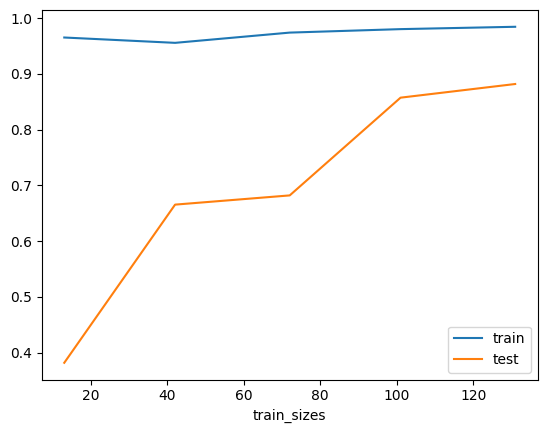

In [6]:
from sklearn.model_selection import learning_curve

N, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5)
# N, train_scores, test_scores = learning_curve(model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 5), cv=5)

print(N)
plt.plot(N, train_scores.mean(axis=1), label='train')
plt.plot(N, test_scores.mean(axis=1), label='test')
plt.xlabel('train_sizes')
plt.legend()

**R2 / RMSE / MAE**

In [7]:
y_pred = model.predict(X_test)

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import *

r2 = r2_score(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
print('R2 :', r2)
print('RMSE :', sqrt(MSE))
print('MAE :', MAE)

R2 : 0.9552475692658176
RMSE : 1879.6108177744484
MAE : 1321.687024390244


**hyperparametre tuning avec GridSearchCV**

In [41]:
from sklearn.model_selection import GridSearchCV
import numpy as np

# n_estimators = np.arange(1,1000)
n_estimators = list(range(10, 1000, 50))
criterion = ['squared_error', 'absolute_error']
max_depth = [4, 5, 6, 7, 8]
min_samples_split = [2, 3, 5, 10]
min_samples_leaf = [1, 2, 4]
min_weight_fraction_leaf = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
max_features = ['auto', 'sqrt', 'log2']
max_leaf_nodes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]
min_impurity_decrease = [0.0]
bootstrap = [True, False]
oob_score = [True, False]
n_jobs = [None]
random_state = [42]
verbose = [0]
warm_start = [True, False]
ccp_alpha = [0.0]
max_samples = [None]

param_grid = {
    'n_estimators': n_estimators,
    'criterion': criterion, 
    'max_depth': max_depth, 
    # 'min_samples_split': min_samples_split, 
    # 'min_samples_leaf': min_samples_leaf, 
    # 'min_weight_fraction_leaf': min_weight_fraction_leaf, 
    'max_features': max_features, 
    # 'max_leaf_nodes': max_leaf_nodes, 
    # 'min_impurity_decrease': min_impurity_decrease, 
    # 'bootstrap': bootstrap, 
    # 'oob_score': oob_score, 
    # 'n_jobs': n_jobs, 
    # 'random_state': random_state, 
    # 'verbose': verbose, 
    # 'warm_start': warm_start, 
    # 'ccp_alpha': ccp_alpha, 
    # 'max_samples': max_samples
}

param_grid2 = {
    'verbose': verbose
#     'memory': [False, True],
#     'steps': [1]
}



grid = GridSearchCV(estimator=model, param_grid=param_grid2, cv=5)

grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f5be63f1cd0>),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f5be63f1ee0>)])),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             param_grid={'verbose': [0]})

In [42]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

ValueError: Invalid parameter 'model' for estimator Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5be404f160>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f5be4003c10>)])),
                ('randomforestregressor', RandomForestRegressor())]). Valid parameters are: ['memory', 'steps', 'verbose'].

In [ ]:
grid.best_score_

In [ ]:
grid.best_params_

In [ ]:
model_grid = grid.best_estimator_

In [ ]:
print('Train set :', model_grid.score(X_train, y_train))
print('Test set :', model_grid.score(X_test, y_test))